In [40]:
import pandas as pd
import sklearn.metrics as met
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import statistics
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

# Binary Prediction of Gentrified Tracts in Melbourne

This noteboke containes the Feed-Forward Neural Networks (FFNN) used to model a binary classification problem about transit-induced gentrification in Melbourne. There are two gentrification periods to be analysed: 2006-2016 and 2011-2016. The training labels were obtained following Freeman's 5-step definition of gentrified areas.

The evaluation process is centered around Recall. In order to do wo while preventing the models from predicting all instances as positive, the main metric is F2 with recall being twice as aimportant as precision.

# Table of Contents

1. [Models for 2006-2016 Gentrification Period](#2006_2016_model)

2. [Models for 2011-2016 Gentrification Period](#2011_2016_model)

In [30]:
# Function to print evaluation metrics

def print_metrics(predictions, y_test, name='model'):
    print('F2 of ' + name + ' is')
    print(met.fbeta_score(y_test, predictions, beta=2))
    print('Recall of ' + name + ' is ')
    print(met.recall_score(y_test, predictions))
    print('Precision of ' + name + ' is ')
    print(met.precision_score(y_test, predictions))
    print('Accuracy of ' + name + ' is ')
    print(met.accuracy_score(y_test, predictions))

In [31]:
# Function to plot Precision-Recall Curve

def plot_PRC(y_test, y_prob, name='model'):
    precision, recall, thresholds = met.precision_recall_curve(y_test, y_prob)
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==True]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label=name)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim(0,1)
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [32]:
# Plot results used to calculate the grand mean of metrics

def plot_series(met_list, name='metric'):
  mean = statistics.mean(met_list)
  plt.plot([0, len(met_list)], [mean, mean], linestyle='--', label='mean')
  plt.plot(met_list, label='series')
  plt.xlabel('series')
  plt.ylabel(name)
  plt.ylim(0,1)
  plt.show

  print('The variance is: ' + str(np.var(met_list)))

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  2006-2016 Gentrification Period <a name='2006_2016_model'></a>

In [34]:
reduced_06_16 = pd.read_csv('drive/MyDrive/dataset_reduced_06_16.csv')
complete_06_16 = pd.read_csv('drive/MyDrive/dataset_complete_06_16.csv')

In [59]:
# Normalize dataset
scaler_R = preprocessing.MinMaxScaler()
X_06R = reduced_06_16.drop(columns = ['SA1_MAINCO','Gentrified_06_16'], axis=1)
X_06R[X_06R.columns] = scaler_R.fit_transform(X_06R)
                                               
scaler_C = preprocessing.MinMaxScaler()
X_06C = complete_06_16.drop(columns = ['SA1_MAINCO','Gentrified_06_16'], axis=1)
X_06C[X_06C.columns] = scaler_C.fit_transform(X_06C)

# Split dataset
X_06R_select, X_06R_test, y_06R_select, y_06R_test = train_test_split(X_06R,
                                                                    reduced_06_16['Gentrified_06_16'], 
                                                                    test_size=0.25)
X_06R_train, X_06R_val, y_06R_train, y_06R_val = train_test_split(X_06R_select,
                                                                    y_06R_select, 
                                                                    test_size=0.25)

X_06C_select, X_06C_test, y_06C_select, y_06C_test = train_test_split(X_06C,
                                                                    complete_06_16['Gentrified_06_16'], 
                                                                    test_size=0.25)
X_06C_train, X_06C_val, y_06C_train, y_06C_val = train_test_split(X_06C_select,
                                                                    y_06C_select, 
                                                                    test_size=0.25)

In [36]:
# Class wights fixed to the proportion of positives and negtives

y_06 = reduced_06_16['Gentrified_06_16']
int_ratio_06 = round(100*len(y_06[y_06 == True])/ len(y_06))

cw_06 = {False: int_ratio_06, True: 100-int_ratio_06}

In [37]:
# metrics

metrics = [tf.keras.metrics.Recall(),
           tf.keras.metrics.Accuracy(),
           tf.keras.metrics.Precision(),
           ]

FFNN trained and configured with a reduced number of demographic features.


Epoch 00001: val_loss improved from inf to 0.81110, saving model to best_model.h5

Epoch 00002: val_loss improved from 0.81110 to 0.51624, saving model to best_model.h5

Epoch 00003: val_loss did not improve from 0.51624

Epoch 00004: val_loss did not improve from 0.51624

Epoch 00005: val_loss did not improve from 0.51624

Epoch 00006: val_loss did not improve from 0.51624

Epoch 00007: val_loss improved from 0.51624 to 0.49284, saving model to best_model.h5

Epoch 00008: val_loss did not improve from 0.49284

Epoch 00009: val_loss did not improve from 0.49284

Epoch 00010: val_loss did not improve from 0.49284

Epoch 00011: val_loss improved from 0.49284 to 0.48217, saving model to best_model.h5

Epoch 00012: val_loss did not improve from 0.48217

Epoch 00013: val_loss did not improve from 0.48217

Epoch 00014: val_loss improved from 0.48217 to 0.47422, saving model to best_model.h5

Epoch 00015: val_loss did not improve from 0.47422

Epoch 00016: val_loss did not improve from 0.474

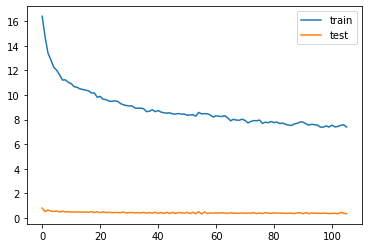

In [55]:
from keras.callbacks import EarlyStopping
from keras.models import load_model

model = Sequential()
model.add(Dense(105, input_dim = X_06R_train.shape[1], activation='selu'))
model.add(Dense(105, activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(105, activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(105, activation='selu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=metrics,)


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', 
                                        monitor='val_loss', 
                                        mode='min', 
                                        verbose=1, 
                                        save_best_only=True)

history = model.fit(x=X_06R_train, 
                    y=y_06R_train, 
                    validation_data=(X_06R_val, y_06R_val),
                    epochs=300,
                    batch_size=2000,
                    class_weight=cw_06,
                    verbose=0,
                    callbacks=[es, mc]
                    )

saved_model = load_model('best_model.h5')

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show

print_metrics(saved_model.predict(X_06R_test).round(),y_06R_test, name='NN')  

F2: 0.714989888830619
recall: 0.8025176233635448
precision: 0.5142858562858137
accuracy: 0.8704624951418578
0.000841153030934499


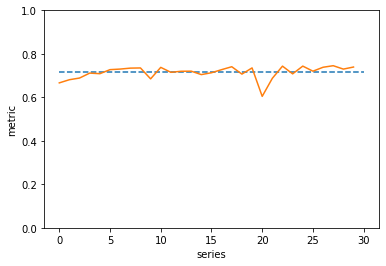

In [56]:
model = Sequential()
model.add(Dense(105, input_dim = X_06R_train.shape[1], activation='selu'))
model.add(Dense(105, activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(105, activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(105, activation='selu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=metrics,)

precision2 = []
acc2 = []
f22 = []
recall2 = []
for i in range(30):

  history = model.fit(x=X_06R_select, 
                    y=y_06R_select, 
                    epochs=50,
                    batch_size=2000,
                    class_weight=cw_06,
                    verbose=0)
                    
  f22.append(met.fbeta_score(y_06R_test, model.predict(X_06R_test).round(), beta=2))
  recall2.append(met.recall_score(y_06R_test, model.predict(X_06R_test).round()))
  precision2.append(met.precision_score(y_06R_test, model.predict(X_06R_test).round()))
  acc2.append(met.accuracy_score(y_06R_test, model.predict(X_06R_test).round()))

print('F2: ' + str(statistics.mean(f22)))
print('recall: ' + str(statistics.mean(recall2)))
print('precision: ' + str(statistics.mean(precision2)))
print('accuracy: ' + str(statistics.mean(acc2)))

plot_series(f22)

FFNN trained and configured with all demographic features.


Epoch 00001: val_loss improved from inf to 4.50800, saving model to best_model.h5

Epoch 00002: val_loss improved from 4.50800 to 0.41403, saving model to best_model.h5

Epoch 00003: val_loss did not improve from 0.41403

Epoch 00004: val_loss improved from 0.41403 to 0.36574, saving model to best_model.h5

Epoch 00005: val_loss did not improve from 0.36574

Epoch 00006: val_loss did not improve from 0.36574

Epoch 00007: val_loss did not improve from 0.36574

Epoch 00008: val_loss did not improve from 0.36574

Epoch 00009: val_loss did not improve from 0.36574

Epoch 00010: val_loss did not improve from 0.36574

Epoch 00011: val_loss did not improve from 0.36574

Epoch 00012: val_loss did not improve from 0.36574

Epoch 00013: val_loss did not improve from 0.36574

Epoch 00014: val_loss did not improve from 0.36574

Epoch 00015: val_loss did not improve from 0.36574

Epoch 00016: val_loss did not improve from 0.36574

Epoch 00017: val_loss did not improve from 0.36574

Epoch 00018: v

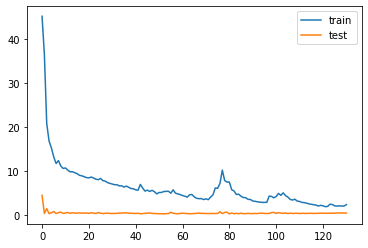

In [61]:
from keras.callbacks import EarlyStopping
from keras.models import load_model

model = Sequential()
model.add(Dense(477, input_dim = X_06C_train.shape[1], activation='selu'))
model.add(Dense(477, activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(477, activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(477, activation='selu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=metrics,)


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', 
                                        monitor='val_loss', 
                                        mode='min', 
                                        verbose=1, 
                                        save_best_only=True)

history = model.fit(x=X_06C_train, 
                    y=y_06C_train, 
                    validation_data=(X_06C_val, y_06C_val),
                    epochs=300,
                    batch_size=2000,
                    class_weight=cw_06,
                    verbose=0,
                    callbacks=[es, mc]
                    )

saved_model = load_model('best_model.h5')

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show

print_metrics(saved_model.predict(X_06C_test).round(),y_06C_test, name='NN')  

F2: 0.6192470235062459
recall: 0.6497435897435897
precision: 0.5613306868118711
accuracy: 0.8821868117631818
0.0006350670912635494


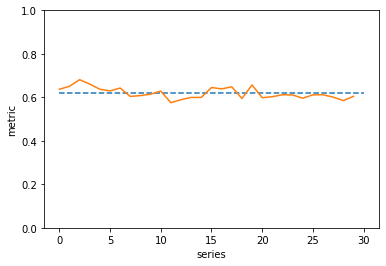

In [63]:
model = Sequential()
model.add(Dense(477, input_dim = X_06C_train.shape[1], activation='selu'))
model.add(Dense(477, activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(477, activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(477, activation='selu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=metrics,)

precision2 = []
acc2 = []
f22 = []
recall2 = []
for i in range(30):

  history = model.fit(x=X_06C_train, 
                    y=y_06C_train, 
                    validation_data=(X_06C_val, y_06C_val),
                    epochs=80,
                    batch_size=2000,
                    class_weight=cw_06,
                    verbose=0,
                    )
                    
  f22.append(met.fbeta_score(y_06C_test, model.predict(X_06C_test).round(), beta=2))
  recall2.append(met.recall_score(y_06C_test, model.predict(X_06C_test).round()))
  precision2.append(met.precision_score(y_06C_test, model.predict(X_06C_test).round()))
  acc2.append(met.accuracy_score(y_06C_test, model.predict(X_06C_test).round()))

print('F2: ' + str(statistics.mean(f22)))
print('recall: ' + str(statistics.mean(recall2)))
print('precision: ' + str(statistics.mean(precision2)))
print('accuracy: ' + str(statistics.mean(acc2)))

plot_series(f22)

The model trained and configured with the a reduced number of demographic features performes better than the complete version, just as it happened with the machine learning models. Overall, the performance regarding F2 and Recall is superior to the baseline (Logistic Regression) and SVM.

##  2011-2016 Gentrification Period <a name='2011_2016_model'></a>

In [65]:
reduced_11_16 = pd.read_csv('drive/MyDrive/dataset_reduced_11_16.csv')
complete_11_16 = pd.read_csv('drive/MyDrive/dataset_complete_11_16.csv')

In [66]:
# Normalize dataset
scaler_R = preprocessing.MinMaxScaler()
X_11R = reduced_11_16.drop(columns = ['SA1_MAINCO','Gentrified_11_16'], axis=1)
X_11R[X_11R.columns] = scaler_R.fit_transform(X_11R)
                                               
scaler_C = preprocessing.MinMaxScaler()
X_11C = complete_11_16.drop(columns = ['SA1_MAINCO','Gentrified_11_16'], axis=1)
X_11C[X_11C.columns] = scaler_C.fit_transform(X_11C)

# Split dataset
X_11R_select, X_11R_test, y_11R_select, y_11R_test = train_test_split(X_11R,
                                                                    reduced_11_16['Gentrified_11_16'], 
                                                                    test_size=0.25)
X_11R_train, X_11R_val, y_11R_train, y_11R_val = train_test_split(X_11R_select,
                                                                    y_11R_select, 
                                                                    test_size=0.25)

X_11C_select, X_11C_test, y_11C_select, y_11C_test = train_test_split(X_11C,
                                                                    complete_11_16['Gentrified_11_16'], 
                                                                    test_size=0.25)
X_11C_train, X_11C_val, y_11C_train, y_11C_val = train_test_split(X_11C_select,
                                                                    y_11C_select, 
                                                                    test_size=0.25)

In [67]:
# Class wights fixed to the proportion of positives and negtives

y_11 = reduced_11_16['Gentrified_11_16']
int_ratio_11 = round(100*len(y_11[y_11 == True])/ len(y_11))

cw_11 = {False: int_ratio_11, True: 100-int_ratio_11}

FFNN trained and configured with a reduced number of demographic features.

F2: 0.5253364214936216
recall: 0.6588447653429603
precision: 0.310047807180849
accuracy: 0.7978494623655914
0.0004788643961352739


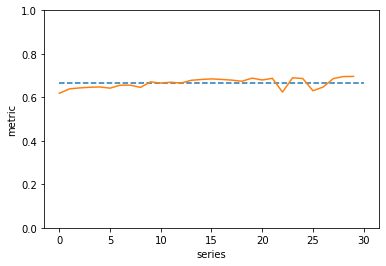

In [68]:
model = Sequential()
model.add(Dense(105, input_dim = X_11R_train.shape[1], activation='selu'))
model.add(Dense(105, activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(105, activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(105, activation='selu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=metrics,)

precision2_11 = []
acc2_11 = []
f22_11 = []
recall2_11 = []
for i in range(30):

  history = model.fit(x=X_11R_select, 
                    y=y_11R_select, 
                    epochs=50,
                    batch_size=2000,
                    class_weight=cw_11,
                    verbose=0)
                    
  f22_11.append(met.fbeta_score(y_11R_test, model.predict(X_11R_test).round(), beta=2))
  recall2_11.append(met.recall_score(y_11R_test, model.predict(X_11R_test).round()))
  precision2_11.append(met.precision_score(y_11R_test, model.predict(X_11R_test).round()))
  acc2_11.append(met.accuracy_score(y_11R_test, model.predict(X_11R_test).round()))

print('F2: ' + str(statistics.mean(f22_11)))
print('recall: ' + str(statistics.mean(recall2_11)))
print('precision: ' + str(statistics.mean(precision2_11)))
print('accuracy: ' + str(statistics.mean(acc2_11)))

plot_series(f22)

FFNN trained and configured with all demographic features.

F2: 0.33870098781108554
recall: 0.3471655328798186
precision: 0.3475788344456706
accuracy: 0.8473766031869413
0.005939197828149366


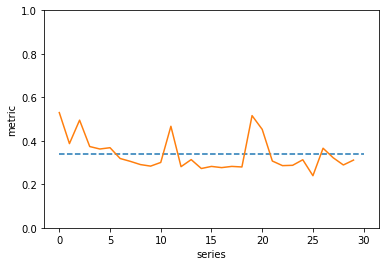

In [69]:
model = Sequential()
model.add(Dense(477, input_dim = X_11C_train.shape[1], activation='selu'))
model.add(Dense(477, activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(477, activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(477, activation='selu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=metrics,)

precision2 = []
acc2 = []
f22 = []
recall2 = []
for i in range(30):

  history = model.fit(x=X_11C_train, 
                    y=y_11C_train, 
                    validation_data=(X_11C_val, y_11C_val),
                    epochs=80,
                    batch_size=2000,
                    class_weight=cw_11,
                    verbose=0,
                    )
                    
  f22.append(met.fbeta_score(y_11C_test, model.predict(X_11C_test).round(), beta=2))
  recall2.append(met.recall_score(y_11C_test, model.predict(X_11C_test).round()))
  precision2.append(met.precision_score(y_11C_test, model.predict(X_11C_test).round()))
  acc2.append(met.accuracy_score(y_11C_test, model.predict(X_11C_test).round()))

print('F2: ' + str(statistics.mean(f22)))
print('recall: ' + str(statistics.mean(recall2)))
print('precision: ' + str(statistics.mean(precision2)))
print('accuracy: ' + str(statistics.mean(acc2)))

plot_series(f22)

Just like in the off-the-shelf machine learning models, the gentrification period between 2011 and 2016 shows a poorer performance.